# Evaluating images (fitness) with an aesthetics predictor

Trained and inspired by Christoph Schuhmann (https://github.com/christophschuhmann/improved-aesthetic-predictor/)
TODO uses the "./testimages" folder

In [3]:
!pip install --upgrade torch ftfy git+https://github.com/openai/CLIP.git gradio pytorch_lightning --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
from model_helpers.auto_device import load_torch_model, auto_clip_device
import torch
import pytorch_lightning as pl
import torch.nn as nn
import clip
from PIL import Image

ModuleNotFoundError: No module named 'pytorch_lightning'

In [4]:
class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)
    # 
    # def training_step(self, batch, batch_idx):
    #         x = batch[self.xcol]
    #         y = batch[self.ycol].reshape(-1, 1)
    #         x_hat = self.layers(x)
    #         loss = F.mse_loss(x_hat, y)
    #         return loss
    # 
    # def validation_step(self, batch, batch_idx):
    #     x = batch[self.xcol]
    #     y = batch[self.ycol].reshape(-1, 1)
    #     x_hat = self.layers(x)
    #     loss = F.mse_loss(x_hat, y)
    #     return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def normalized(a, axis=-1, order=2):
    import numpy as np  # pylint: disable=import-outside-toplevel

    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

device = auto_clip_device()
predictor_model_path = "./models/sac+logos+ava1-l14-linearMSE.pth"
url = "https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/main/sac+logos+ava1-l14-linearMSE.pth"
predictor_model = load_torch_model(predictor_model_path, url, device=device)
model = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
model.load_state_dict(predictor_model)
model.to(device)
model.eval() # Finalize model

clip_model, preprocess = clip.load("ViT-L/14", device=device) 

Model loaded successfully.


## Simple inference

Aesthetic score predicted by the model:
tensor([[5.7360]])


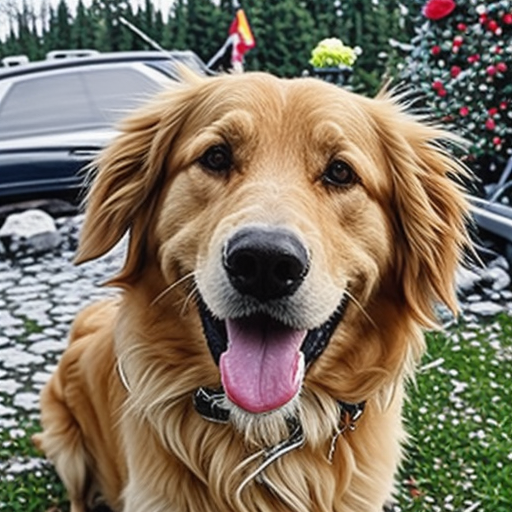

In [14]:
pil_image = Image.open("./testimages/0.png")
image = preprocess(pil_image).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image)
    im_emb_arr = normalized(image_features.cpu().detach().numpy())
    prediction = model(torch.from_numpy(im_emb_arr).to(device))

print("Aesthetic score predicted by the model:")
print(prediction)
pil_image